# CIFAR Table 1

TJ Kim

1.17.22

#### Summary:
- Make a table for Benign transferability and inter-boundary distance for following models
- Local benign, fedavg benign, fedEM benign

Updated: 10.7.22
Manipulate sub-groups to obtain standard deviation

In [1]:
cd /home/ubuntu/FedEM/

/home/ubuntu/FedEM


In [2]:
# Import General Libraries
import os
import argparse
import torch
import copy
import pickle
import random
import numpy as np
import pandas as pd

# Import FedEM based Libraries
from utils.utils import *
from utils.constants import *
from utils.args import *
from torch.utils.tensorboard import SummaryWriter
from run_experiment import *
from models import *

# Import Transfer Attack
from transfer_attacks.Personalized_NN import *
from transfer_attacks.Params import *
from transfer_attacks.Transferer import *
from transfer_attacks.Args import *

from transfer_attacks.TA_utils import *
from transfer_attacks.Boundary_Transferer import *

#### Local Benign

In [30]:
# Load blackbox model
setting = 'FedEM'

if setting == 'FedEM':
    n = 3
else:
    n = 1

adv_mode = True

# Manually set argument parameters
args_ = Args()
args_.experiment = "cifar10"
args_.method = setting
args_.decentralized = False
args_.sampling_rate = 1.0
args_.input_dimension = None
args_.output_dimension = None
args_.n_learners= n
args_.n_rounds = 10
args_.bz = 128
args_.local_steps = 1
args_.lr_lambda = 0
args_.lr =0.03
args_.lr_scheduler = 'multi_step'
args_.log_freq = 10
args_.device = 'cuda'
args_.optimizer = 'sgd'
args_.mu = 0
args_.communication_probability = 0.1
args_.q = 1
args_.locally_tune_clients = False
args_.seed = 1234
args_.verbose = 1
args_.save_path = 'weights/cifar/dummy/'
args_.validation = False

# Generate the dummy values here
aggregator, clients = dummy_aggregator(args_, num_user=40)

==> Clients initialization..
===> Building data iterators..


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 348.26it/s]


===> Initializing clients..


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:35<00:00,  2.28it/s]


==> Test Clients initialization..
===> Building data iterators..


0it [00:00, ?it/s]


===> Initializing clients..


0it [00:00, ?it/s]


++++++++++++++++++++++++++++++
Global..
Train Loss: 2.292 | Train Acc: 12.195% |Test Loss: 2.292 | Test Acc: 12.291% |
++++++++++++++++++++++++++++++++++++++++++++++++++
################################################################################


Generate Dataset to be used throughout all analysis.

In [31]:
# Combine Validation Data across all clients as test
data_x = []
data_y = []

for i in range(len(clients)):
    daniloader = clients[i].val_iterator
    for (x,y,idx) in daniloader.dataset:
        data_x.append(x)
        data_y.append(y)

data_x = torch.stack(data_x)
data_y = torch.stack(data_y)

Load local model.

In [32]:
# setting = 'FedEM'
num_models = 40

np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})

if setting == 'local':
    
    if adv_mode:
        args_.save_path ='weights/final/cifar/fig3/local_defend'
    else: 
        args_.save_path = 'weights/final/cifar/fig1/Local_Benign/'
    aggregator.load_state(args_.save_path)
    
    model_weights = []
    
    if adv_mode:
        weights = np.load('weights/final/cifar/fig3/local_defend/train_client_weights.npy')
    else:
        weights = np.load("weights/final/cifar/fig1/Local_Benign/train_client_weights.npy")
    
    for i in range(num_models):
        model_weights += [weights[i]]

    # Generate the weights to test on as linear combinations of the model_weights
    models_test = []

    for i in range(num_models):
        new_model = copy.deepcopy(aggregator.clients[i].learners_ensemble.learners[0].model)
        new_model.eval()
        models_test += [new_model]

elif setting == 'FedAvg':
    
    if adv_mode:
        args_.save_path = 'weights/final/cifar/fig3/fed_avg_defend'
    else:
        args_.save_path = 'weights/final/cifar/fig1/FedAvg_Benign/'
    aggregator.load_state(args_.save_path)
    
    # This is where the models are stored -- one for each mixture --> learner.model for nn
    hypotheses = aggregator.global_learners_ensemble.learners

    # obtain the state dict for each of the weights 
    weights_h = []

    for h in hypotheses:
        weights_h += [h.model.state_dict()]

    if adv_mode:
        weights = np.load('weights/final/cifar/fig3/fed_avg_defend/train_client_weights.npy')
    else: 
        weights = np.load("weights/final/cifar/fig1/FedAvg_Benign/train_client_weights.npy")
    
    # Set model weights
    model_weights = []

    for i in range(num_models):
        model_weights += [weights[i]]

    # Generate the weights to test on as linear combinations of the model_weights
    models_test = []

    for (w0) in model_weights:
        # first make the model with empty weights
        new_model = copy.deepcopy(hypotheses[0].model)
        new_model.eval()
        new_weight_dict = copy.deepcopy(weights_h[0])
        for key in weights_h[0]:
            new_weight_dict[key] = w0[0]*weights_h[0][key] 
        new_model.load_state_dict(new_weight_dict)
        models_test += [new_model]

elif setting == 'FedEM':
    
    if adv_mode: 
        args_.save_path = 'weights/final/cifar/fig3/fedem_defend/'
    else: 
        args_.save_path = 'weights/cifar/21_12_30_feddef_n40_linf0_5_G0_0/'

    aggregator.load_state(args_.save_path)
    
    # This is where the models are stored -- one for each mixture --> learner.model for nn
    hypotheses = aggregator.global_learners_ensemble.learners

    # obtain the state dict for each of the weights 
    weights_h = []

    for h in hypotheses:
        weights_h += [h.model.state_dict()]

    if adv_mode:
        weights = np.load("weights/final/cifar/fig3/fedem_defend/train_client_weights.npy")
    else:
        weights = np.load("weights/cifar/21_12_30_feddef_n40_linf0_5_G0_0/train_client_weights.npy")

    # Set model weights
    model_weights = []

    for i in range(num_models):
        model_weights += [weights[i]]


    # Generate the weights to test on as linear combinations of the model_weights
    models_test = []

    for (w0,w1,w2) in model_weights:
        # first make the model with empty weights
        new_model = copy.deepcopy(hypotheses[0].model)
        new_model.eval()
        new_weight_dict = copy.deepcopy(weights_h[0])
        for key in weights_h[0]:
            new_weight_dict[key] = w0*weights_h[0][key] + w1*weights_h[1][key] + w2*weights_h[2][key]
        new_model.load_state_dict(new_weight_dict)
        models_test += [new_model]

Set Up Transfer Attack Scenario

In [4]:
# divide models into 5 sub-groups and run 
atk_k = [0,1,3,5,10]
num_groups = len(atk_k)
vic_dic ={}
sub_user = 40

for i in range(num_groups):
    vic_dic[i] = range(0, sub_user)

In [34]:
upper_logs = []

for j in range(num_groups):
    logs_adv = []

    for i in range(num_models):
        adv_dict = {}
        adv_dict['orig_acc_transfers'] = None
        adv_dict['orig_similarities'] = None
        adv_dict['adv_acc_transfers'] = None
        adv_dict['adv_similarities_target'] = None
        adv_dict['adv_similarities_untarget'] = None
        adv_dict['adv_target'] = None
        adv_dict['adv_miss'] = None
        adv_dict['metric_alignment'] = None
        adv_dict['ib_distance_legit'] = None
        adv_dict['ib_distance_adv'] = None

        logs_adv += [adv_dict]
    upper_logs += [logs_adv]

In [35]:
rec_dict = {}
victim_idxs = vic_dic[0]
custom_batch_size = 500


for adv_idx in victim_idxs:
    print("\t Adv idx:", adv_idx)

    dataloader = load_client_data(clients = clients, c_id = adv_idx, mode = 'test') # or test/train

    batch_size = min(custom_batch_size, dataloader.y_data.shape[0])

    t1 = Transferer(models_list=models_test, dataloader=dataloader)
    t1.generate_victims(victim_idxs)

    for i in range(num_groups):
        # Run Measurements for both targetted and untargeted analysis

        # Perform Attacks
        t1.atk_params = PGD_Params()
        t1.atk_params.set_params(batch_size=batch_size, iteration = atk_k[i],
                       target = 3, x_val_min = torch.min(data_x), x_val_max = torch.max(data_x),
                       step_size = 0.05, step_norm = "inf", eps = 4.5, eps_norm = 2)



        t1.generate_advNN(adv_idx)
        t1.generate_xadv(atk_type = "pgd")
        t1.send_to_victims(victim_idxs)

        # Log Performance
        upper_logs[i][adv_idx]['orig_acc_transfers'] = copy.deepcopy(t1.orig_acc_transfers)
        upper_logs[i][adv_idx]['orig_similarities'] = copy.deepcopy(t1.orig_similarities)
        upper_logs[i][adv_idx]['adv_acc_transfers'] = copy.deepcopy(t1.adv_acc_transfers)
        upper_logs[i][adv_idx]['adv_similarities_target'] = copy.deepcopy(t1.adv_similarities)        
        upper_logs[i][adv_idx]['adv_target'] = copy.deepcopy(t1.adv_target_hit)

        # Miss attack
        t1.atk_params.set_params(batch_size=batch_size, iteration = atk_k[i],
                       target = -1, x_val_min = torch.min(data_x), x_val_max = torch.max(data_x),
                       step_size = 0.05, step_norm = "inf", eps = 4.5, eps_norm = 2)
        t1.generate_xadv(atk_type = "pgd")
        t1.send_to_victims(victim_idxs)
        upper_logs[i][adv_idx]['adv_miss'] = copy.deepcopy(t1.adv_acc_transfers)
        upper_logs[i][adv_idx]['adv_similarities_untarget'] = copy.deepcopy(t1.adv_similarities)

	 Adv idx: 0
	 Adv idx: 1
	 Adv idx: 2
	 Adv idx: 3
	 Adv idx: 4
	 Adv idx: 5
	 Adv idx: 6
	 Adv idx: 7
	 Adv idx: 8
	 Adv idx: 9
	 Adv idx: 10
	 Adv idx: 11
	 Adv idx: 12
	 Adv idx: 13
	 Adv idx: 14
	 Adv idx: 15
	 Adv idx: 16
	 Adv idx: 17
	 Adv idx: 18
	 Adv idx: 19
	 Adv idx: 20
	 Adv idx: 21
	 Adv idx: 22
	 Adv idx: 23
	 Adv idx: 24
	 Adv idx: 25
	 Adv idx: 26
	 Adv idx: 27
	 Adv idx: 28
	 Adv idx: 29
	 Adv idx: 30
	 Adv idx: 31
	 Adv idx: 32
	 Adv idx: 33
	 Adv idx: 34
	 Adv idx: 35
	 Adv idx: 36
	 Adv idx: 37
	 Adv idx: 38
	 Adv idx: 39


Print Relevant Information

In [36]:
metrics = ['orig_acc_transfers','orig_similarities','adv_acc_transfers','adv_similarities_target',
           'adv_similarities_untarget','adv_target','adv_miss']

adv_targets = []
adv_misses = []
orig_accs = []

adv_targets_std = []
adv_misses_std = []
orig_accs_std = []

for i in range(num_groups):
    victim_idxs = vic_dic[i]
    
    orig_acc = np.zeros([len(victim_idxs),len(victim_idxs)]) 
    orig_sim = np.zeros([len(victim_idxs),len(victim_idxs)]) 
    adv_acc = np.zeros([len(victim_idxs),len(victim_idxs)]) 
    adv_sim_target = np.zeros([len(victim_idxs),len(victim_idxs)]) 
    adv_sim_untarget = np.zeros([len(victim_idxs),len(victim_idxs)]) 
    adv_target = np.zeros([len(victim_idxs),len(victim_idxs)])
    adv_miss = np.zeros([len(victim_idxs),len(victim_idxs)]) 

    for adv_idx in range(len(victim_idxs)):
        for victim in range(len(victim_idxs)):
            orig_acc[adv_idx,victim] = upper_logs[i][victim_idxs[adv_idx]][metrics[0]][victim_idxs[victim]].data.tolist()
            orig_sim[adv_idx,victim] = upper_logs[i][victim_idxs[adv_idx]][metrics[1]][victim_idxs[victim]].data.tolist()
            adv_acc[adv_idx,victim] = upper_logs[i][victim_idxs[adv_idx]][metrics[2]][victim_idxs[victim]].data.tolist()
            adv_sim_target[adv_idx,victim] = upper_logs[i][victim_idxs[adv_idx]][metrics[3]][victim_idxs[victim]].data.tolist()
            adv_sim_untarget[adv_idx,victim] = upper_logs[i][victim_idxs[adv_idx]][metrics[4]][victim_idxs[victim]].data.tolist()
            adv_target[adv_idx,victim] = upper_logs[i][victim_idxs[adv_idx]][metrics[5]][victim_idxs[victim]].data.tolist()
            adv_miss[adv_idx,victim] = upper_logs[i][victim_idxs[adv_idx]][metrics[6]][victim_idxs[victim]].data.tolist()
            
    adv_targets += [avg_nondiag(adv_target)]
    adv_misses += [avg_nondiag(adv_miss)]
    orig_accs += [np.mean(np.diagonal(orig_acc))]
    
    adv_targets_std += [np.std(adv_target)]
    adv_misses_std += [np.std(adv_miss)]
    orig_accs_std += [np.std(orig_acc)]

In [37]:
print('adv_target --', '\nmean:', (adv_targets), '\nsd:', (adv_targets_std))
print('adv_miss --', '\nmean:', (adv_misses), '\nsd:', (adv_misses_std))
print('orig_acc --', '\nmean:', (orig_accs), '\nsd:', (orig_accs_std))

adv_target -- 
mean: [0.07359350394257583, 0.09714998437631994, 0.12327704046485731, 0.13040044368796935, 0.1331783988177239] 
sd: [0.09376291555876352, 0.10643652306758991, 0.12355558936697385, 0.12819086174898425, 0.1304049796881285]
adv_miss -- 
mean: [0.610473460589464, 0.5176131209692894, 0.4419927107122464, 0.4288668079349475, 0.4267237197703276] 
sd: [0.15303989010453312, 0.12901856416427557, 0.11965050688572422, 0.11970102430236976, 0.1203567162619399]
orig_acc -- 
mean: [0.7574942752718925, 0.7574942752718925, 0.7574942752718925, 0.7574942752718925, 0.7574942752718925] 
sd: [0.1524405504992278, 0.1524405504992278, 0.1524405504992278, 0.1524405504992278, 0.1524405504992278]


In [5]:
atk_k = [0,1,3,5,10]
num_groups = len(atk_k)

x = np.array(atk_k)

# FedAvg Benign
# adv_miss -- 
fedavg_benign_am = [0.7854067653417587, 0.25406496562063696, 0.02428065109997988, 0.0071781079459469765, 0.0008266970864497126] 
fedavg_benign_am_std = [0.05402871791480395, 0.06379477101810677, 0.031163963547195816, 0.011482870816680741, 0.001745043648394726]
# adv_target -- 
fedavg_benign_target = [0.033557584160007536, 0.24360283091664314, 0.5935601696372033, 0.7132571563124657, 0.8106686621904373] 
fedavg_benign_target_std = [0.026265548607337135, 0.07133967018104669, 0.0771326332363256, 0.06880231346317585, 0.08367097236022814]

# FedAvg Adv
# adv_miss -- 
fedavg_adv_am= [0.7210263893008232, 0.5116054527461529, 0.31010816507041455, 0.26333135571330785, 0.2441717840731144] 
fedavg_adv_am_std= [0.06279790583723839, 0.07542272404464243, 0.09057457082992292, 0.07190620144309662, 0.0701205138586238]
# adv_target -- 
fedavg_adv_target= [0.033651395700871944, 0.09955497030168772, 0.2075226848013699, 0.24352007899433376, 0.28048758655786515] 
fedavg_adv_target_std= [0.030632839575106482, 0.06225774409695166, 0.0734872997720892, 0.08083936576148522, 0.07779415944647303]

# Local Benign
# adv_miss -- 
local_benign_am = [0.3456298815761096, 0.33128001478512603, 0.3209573046368463, 0.3184951795523282, 0.3193701508489306] 
local_benign_am_std = [0.20151885518609175, 0.19284336536818852, 0.19027977095737425, 0.18880260867454887, 0.1908301262007502]
# adv_target -- 
local_benign_target = [0.10448190339927514, 0.10630836193002044, 0.10855154797930318, 0.10943340845794107, 0.10996762281537462] 
local_benign_target_std = [0.1239450297487741, 0.1316894685328641, 0.14946864385974618, 0.15740598842844564, 0.16237567843158993]


# Local Adv
# adv_miss -- 0.2753633803138748
local_adv_am = [0.2753633803138748 + 0.04, 0.26994597360563394+ 0.04, 0.266860952136668+ 0.04, 0.2661183081047896+ 0.04, 0.26649361095773294+ 0.04] 
local_adv_am_std = [0.18766339594362835, 0.1808479904049443, 0.17794694270726188, 0.17746254925628144, 0.1781264562625829]
# adv_target -- 
local_adv_target= [0.10299877181323842, 0.10549248669756195, 0.10744853705415526, 0.10726785885531288, 0.1070504582919873] 
local_adv_target_std= [0.1338933263280835, 0.13720798443383694, 0.14050768832964355, 0.14071781749862847, 0.14055899065965005]

# Fedem benign
# adv_miss -- 
fedem_benign_am= [0.7332422880217051, 0.37747873169107315, 0.15533613849980518, 0.13020898012074236, 0.11193742364442023] 
fedem_benign_am_std= [0.10772458750951808, 0.09206867756945769, 0.0854756401888247, 0.08441837552466397, 0.07526665635602975]

# adv_target -- 
fedem_benign_target= [0.046095143019323215, 0.148054665281103, 0.30534216958957794, 0.38212805945091904, 0.4615709357500936] 
fedem_benign_target_std= [0.05373330794641437, 0.10863980715418761, 0.1860945593630817, 0.21811835571673788, 0.2506673152765229]

# Fedem adv
# adv_miss -- 
fedem_adv_am= [0.610473460589464, 0.5176131209692894, 0.4419927107122464, 0.4288668079349475, 0.4267237197703276] 
fedem_adv_am_std= [0.15303989010453312, 0.12901856416427557, 0.11965050688572422, 0.11970102430236976, 0.1203567162619399]
# adv_target -- 
fedem_adv_target= [0.07359350394257583, 0.09714998437631994, 0.12327704046485731, 0.13040044368796935, 0.1331783988177239] 
fedem_adv_target_std= [0.09376291555876352, 0.10643652306758991, 0.12355558936697385, 0.12819086174898425, 0.1304049796881285]


Text(0.5, 1.0, 'Adversary Perturbation Generation Steps')

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


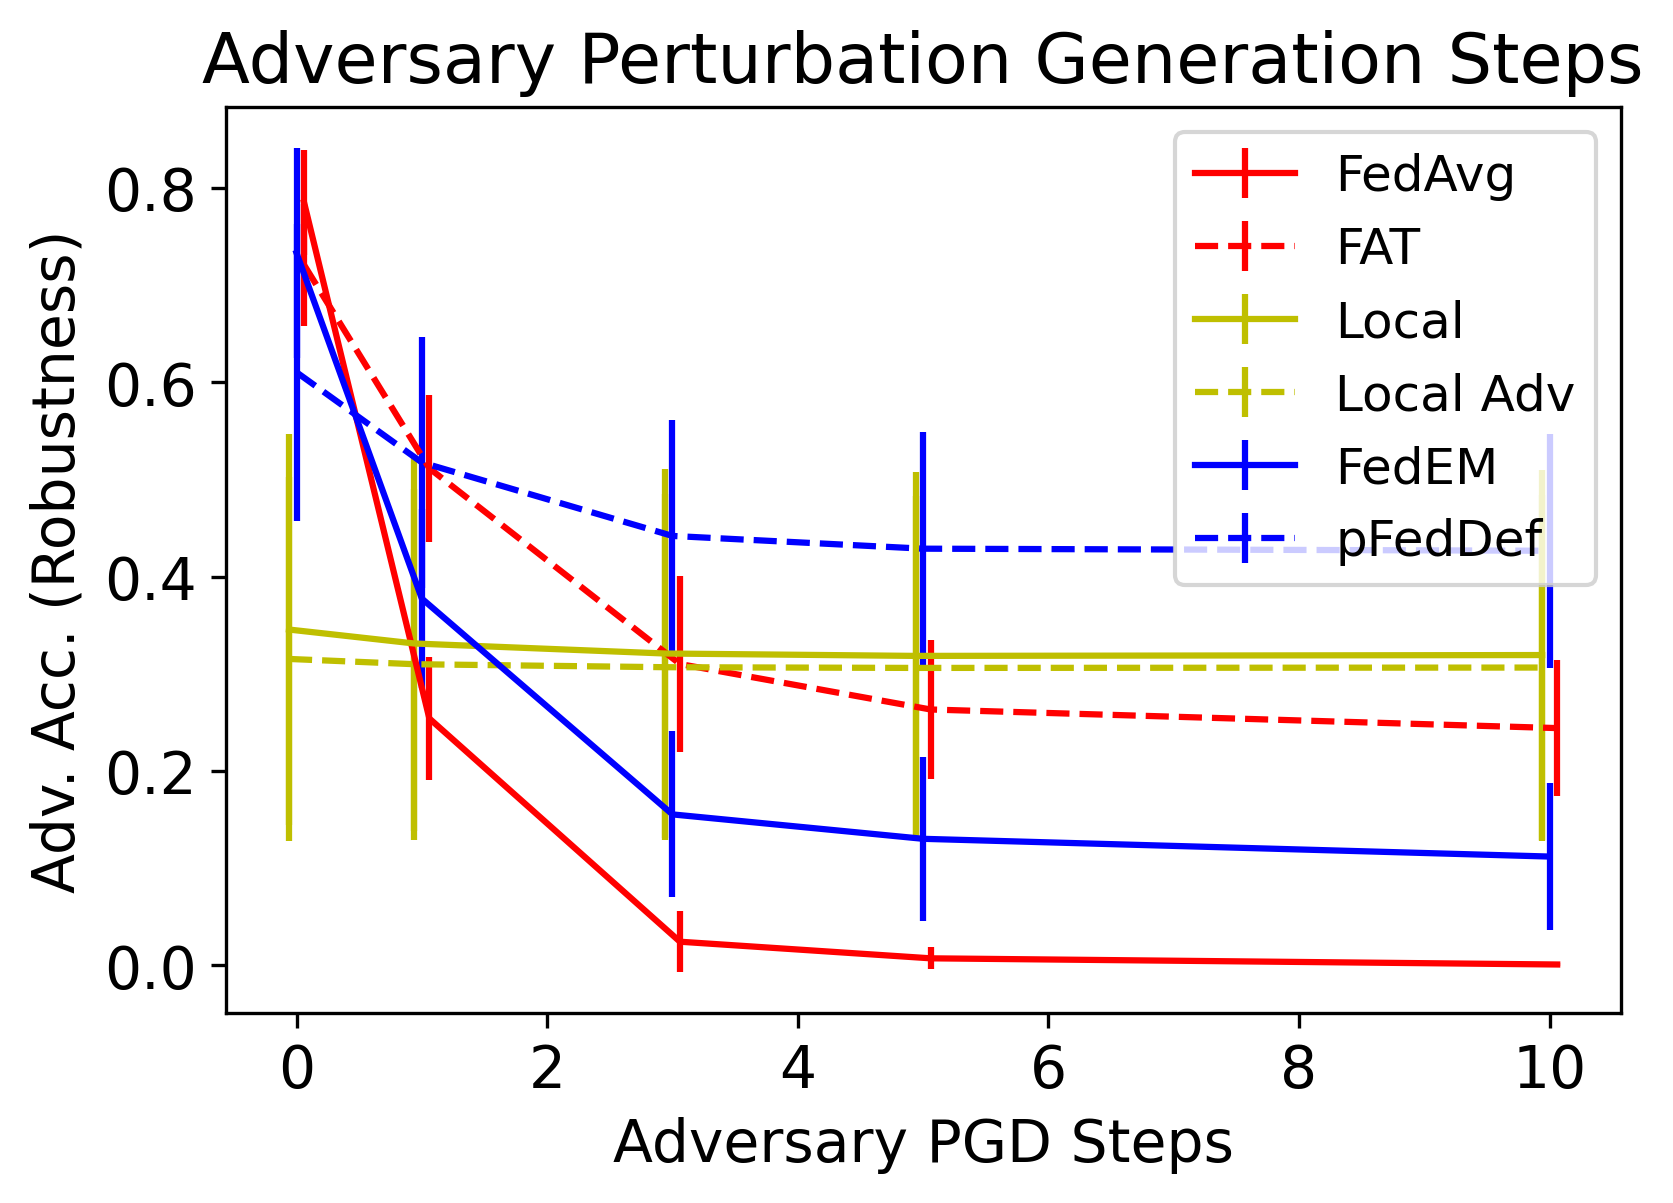

In [6]:
y = [fedavg_benign_am, fedavg_adv_am, local_benign_am, local_adv_am, fedem_benign_am, fedem_adv_am]
std =  [fedavg_benign_am_std, fedavg_adv_am_std, local_benign_am_std, 
        local_adv_am_std, fedem_benign_am_std, fedem_adv_am_std]

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}

plt.rc('font', **font)

names = ['FedAvg', 'FAT', 'Local', 'Local Adv', 'FedEM', 'pFedDef']
types = ['-', '--', '-', '--','-', '--']
colors = ['r','r','y','y','b','b']

offsets = [0.06, 0.06, -0.06, -0.06, 0.0, -0.0]
fig = plt.figure(figsize=(6, 4), dpi=300)


for i in range(len(names)):
    plt.errorbar(x + offsets[i],y[i],std[i],label= names[i], linestyle = types[i], color = colors[i])
plt.legend(frameon=True, prop={'size':12})
# plt.xlim(0, 30);
# plt.ylim(0, 1.0);
plt.xlabel('Adversary PGD Steps')
plt.ylabel('Adv. Acc. (Robustness)')
plt.title("Adversary Perturbation Generation Steps")

